## DRAGON *DualFinder*: An Instance of the DRAGON CNN Architecture Specialized for Dual AGN Detection.
### Authors: Isaac Moskowitz and Jeremy Ng
### Collaborators: C. Meg Urry (PI), Aritra Ghosh. 
#### Began June 7, 2024


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import logging
import pandas as pd
import csv
import sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score 
from keras import backend as K
import os
from os.path import exists
#import tensorflow_addons as tfa
import shutil
#from dual_finder import DualFinder, loadModelClass
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from astropy.io import fits

sys.path.append("DRAGON_Dual_Finder/dual_finder/cnn/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/optimize/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/preprocess_data/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/visualize/")
from create_cnn import ModelCreator
from load_model import loadModelClass
from train_cnn import DualFinder
from extract_feature_maps import FeatureExtractor
from fits_utils import plot_dataset_sample
from process_data import make_datasets_other_bands, create_dataset
from optimize_hyperparameters import OptimizeHyperparameters
from visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization

2024-06-14 09:48:31.735435: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 09:48:32.532198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 09:48:32.532245: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 09:48:32.537731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-14 09:48:32.940995: I tensorflow/core/platform/cpu_feature_g

GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12883915840427824154
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32647086080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10116416161925150891
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2024-06-14 09:48:55.773654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


In [2]:
#os.chdir("~/")
#!pwd
empty_sky_filepath = "data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/"
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
offset_AGN_filepath = 'data_preprocessing/training_datasets/offset_AGN_datasets/train_data/'
stellar_filepath = "data_preprocessing/training_datasets/stellar_dataset/train_data/"
train_data_labels, val_data_labels, test_data_labels = create_dataset(empty_sky_filepath = empty_sky_filepath,
                                                                      dual_image_filepath = dual_AGN_filepath,
                                                                      stellar_filepath = stellar_filepath,
                                                                     offset_image_filepath = offset_AGN_filepath,
                                                                     single_image_filepath = single_AGN_filepath)
train_dataset, train_labels, train_filepaths = train_data_labels
val_dataset, val_labels, val_filepaths = val_data_labels
test_dataset, test_labels, test_filepaths = test_data_labels


2024-06-14 09:48:57,505 - INFO - Loading images from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ with label empty_sky...
100%|██████████| 9215/9215 [00:39<00:00, 230.45it/s]
0it [00:00, ?it/s]2024-06-14 09:49:38.073264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
9215it [00:55, 165.57it/s]
2024-06-14 09:50:35,293 - INFO - Loading images from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/ with label single_AGN...


Loaded 36860 images with 36860 labels from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/


100%|██████████| 2000/2000 [00:08<00:00, 226.17it/s]
2000it [00:20, 99.98it/s] 
2024-06-14 09:51:04,775 - INFO - Loading images from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with label dual_AGN...


Loaded 12000 images with 12000 labels from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/
Length of single AGN images: 12000


100%|██████████| 35492/35492 [01:43<00:00, 344.56it/s]
2024-06-14 09:52:49,437 - INFO - expanding dims
2024-06-14 09:52:49,438 - INFO - Loading images from data_preprocessing/training_datasets/offset_AGN_datasets/train_data/ with label offset_AGN...


Loaded 35492 images with 35492 labels from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/


100%|██████████| 28756/28756 [01:42<00:00, 279.52it/s]
2024-06-14 09:54:33,427 - INFO - expanding dims
2024-06-14 09:54:33,428 - INFO - Loading images from data_preprocessing/training_datasets/stellar_dataset/train_data/ with label star_AGN_align...


Loaded 28756 images with 28756 labels from data_preprocessing/training_datasets/offset_AGN_datasets/train_data/


 60%|██████    | 16995/28319 [01:04<00:39, 287.75it/s]WARNING: File may have been truncated: actual file length (38224) is smaller than the expected size (40320) [astropy.io.fits.file]
2024-06-14 09:55:38,960 - WARNING - File may have been truncated: actual file length (38224) is smaller than the expected size (40320)
100%|██████████| 28319/28319 [01:48<00:00, 261.61it/s]
2024-06-14 09:56:22,900 - INFO - expanding dims


Loaded 28319 images with 28319 labels from data_preprocessing/training_datasets/stellar_dataset/train_data/
Length of stellar images: (28319, 94, 94)
Total images: (141427, 94, 94, 1)
Total labels: (141427,)
Total filepaths: (141427,)
Train_dataset: (91927, 94, 94, 1)
Train_labels: (91927,)
Train_filepaths: (91927,)
Val_dataset: (28285, 94, 94, 1)
Val_labels: (28285,)
Val_filepaths: (28285,)
Test_dataset: (21215, 94, 94, 1)
Test_labels: (21215,)
Test_filepaths: (21215,)


In [3]:
print(np.shape(val_dataset))
print(np.shape(val_labels))

(28285, 94, 94, 1)
(28285,)


In [16]:
image_shape = (94,94,1)
epoch = 20
batch_size = 64
init_learning_rate = 1e-5
num_classes = 5
model_type = 'dualfinder'
importance_score = [1.0, 1.0]

dual_finder_instance = DualFinder(train_dataset, val_dataset, image_shape, train_labels, val_labels, epoch, batch_size, init_learning_rate, num_classes, model_type, importance_score, display_architecture = True)
history, dual_finder_model = dual_finder_instance.trainCNN(dropout_rate = 0.5, save_feature_maps = False)

['dual_AGN' 'offset_AGN' 'offset_AGN' ... 'star_AGN_align' 'dual_AGN'
 'empty_sky']
['offset_AGN' 'offset_AGN' 'offset_AGN' ... 'empty_sky' 'offset_AGN'
 'dual_AGN']
Converting to list
Converting to list
train_labels shape: (91927, 5)
val_labels shape: (28285, 5)
Unique train labels: [0. 1.]
Unique val labels: [0. 1.]
5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 94, 94, 1)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 94, 94, 64)        640       
                                                                 
 dropout_24 (Dropout)        (None, 94, 94, 64)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 94, 94, 64)        256       
 tchNormalization)                                            

2024-06-14 12:27:05,883 - INFO - 'save_feature_maps' == False, NOT saving feature maps


train_images shape: (91927, 94, 94, 1)
train_labels shape: (91927, 5)
val_images shape: (28285, 94, 94, 1)
val_labels shape: (28285, 5)
Epoch 1/20


2024-06-14 12:27:11.074153: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2873/2873 [==============================] - ETA: 0s - loss: 26.5199 - accuracy: 0.9243 - precision: 0.9439 - recall: 0.9037 - f1_score: 0.9024INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:29:30,652 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 142s 48ms/step - loss: 26.5199 - accuracy: 0.9243 - precision: 0.9439 - recall: 0.9037 - f1_score: 0.9024 - val_loss: 21.1439 - val_accuracy: 0.6388 - val_precision: 0.6459 - val_recall: 0.6351 - val_f1_score: 0.5925
Epoch 2/20
2873/2873 [==============================] - ETA: 0s - loss: 15.0622 - accuracy: 0.9807 - precision: 0.9815 - recall: 0.9799 - f1_score: 0.9723INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:31:46,480 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 15.0622 - accuracy: 0.9807 - precision: 0.9815 - recall: 0.9799 - f1_score: 0.9723 - val_loss: 12.3529 - val_accuracy: 0.8438 - val_precision: 0.8522 - val_recall: 0.8366 - val_f1_score: 0.8191
Epoch 3/20
2873/2873 [==============================] - ETA: 0s - loss: 9.5916 - accuracy: 0.9862 - precision: 0.9867 - recall: 0.9858 - f1_score: 0.9802INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:34:02,322 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 9.5916 - accuracy: 0.9862 - precision: 0.9867 - recall: 0.9858 - f1_score: 0.9802 - val_loss: 11.2078 - val_accuracy: 0.6302 - val_precision: 0.6318 - val_recall: 0.6271 - val_f1_score: 0.5775
Epoch 4/20
2873/2873 [==============================] - ETA: 0s - loss: 6.4361 - accuracy: 0.9893 - precision: 0.9897 - recall: 0.9889 - f1_score: 0.9845INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:36:18,624 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 6.4361 - accuracy: 0.9893 - precision: 0.9897 - recall: 0.9889 - f1_score: 0.9845 - val_loss: 5.5290 - val_accuracy: 0.9272 - val_precision: 0.9290 - val_recall: 0.9260 - val_f1_score: 0.9060
Epoch 5/20
2873/2873 [==============================] - ETA: 0s - loss: 4.4136 - accuracy: 0.9922 - precision: 0.9924 - recall: 0.9921 - f1_score: 0.9888INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:38:34,609 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 4.4136 - accuracy: 0.9922 - precision: 0.9924 - recall: 0.9921 - f1_score: 0.9888 - val_loss: 6.2196 - val_accuracy: 0.5446 - val_precision: 0.5456 - val_recall: 0.5435 - val_f1_score: 0.4563
Epoch 6/20
2873/2873 [==============================] - ETA: 0s - loss: 3.0409 - accuracy: 0.9934 - precision: 0.9935 - recall: 0.9933 - f1_score: 0.9906INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:40:50,373 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 3.0409 - accuracy: 0.9934 - precision: 0.9935 - recall: 0.9933 - f1_score: 0.9906 - val_loss: 2.8073 - val_accuracy: 0.8670 - val_precision: 0.8694 - val_recall: 0.8640 - val_f1_score: 0.8572
Epoch 7/20
2873/2873 [==============================] - ETA: 0s - loss: 2.0861 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9949 - f1_score: 0.9928INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:43:06,590 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 2.0861 - accuracy: 0.9950 - precision: 0.9951 - recall: 0.9949 - f1_score: 0.9928 - val_loss: 2.1147 - val_accuracy: 0.8607 - val_precision: 0.8671 - val_recall: 0.8543 - val_f1_score: 0.8425
Epoch 8/20
2872/2873 [============================>.] - ETA: 0s - loss: 1.4391 - accuracy: 0.9953 - precision: 0.9955 - recall: 0.9952 - f1_score: 0.9933INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:45:22,441 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 1.4391 - accuracy: 0.9953 - precision: 0.9955 - recall: 0.9952 - f1_score: 0.9933 - val_loss: 1.4059 - val_accuracy: 0.9195 - val_precision: 0.9224 - val_recall: 0.9148 - val_f1_score: 0.9131
Epoch 9/20
2873/2873 [==============================] - ETA: 0s - loss: 1.0289 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9953 - f1_score: 0.9933INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:47:38,552 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 1.0289 - accuracy: 0.9954 - precision: 0.9955 - recall: 0.9953 - f1_score: 0.9933 - val_loss: 0.8737 - val_accuracy: 0.9952 - val_precision: 0.9954 - val_recall: 0.9952 - val_f1_score: 0.9934
Epoch 10/20
2873/2873 [==============================] - ETA: 0s - loss: 0.7548 - accuracy: 0.9964 - precision: 0.9965 - recall: 0.9963 - f1_score: 0.9948INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:49:54,231 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 0.7548 - accuracy: 0.9964 - precision: 0.9965 - recall: 0.9963 - f1_score: 0.9948 - val_loss: 0.6341 - val_accuracy: 0.9981 - val_precision: 0.9982 - val_recall: 0.9981 - val_f1_score: 0.9977
Epoch 11/20
2873/2873 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.9964 - precision: 0.9965 - recall: 0.9964 - f1_score: 0.9948INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:52:09,727 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 135s 47ms/step - loss: 0.5514 - accuracy: 0.9964 - precision: 0.9965 - recall: 0.9964 - f1_score: 0.9948 - val_loss: 0.4704 - val_accuracy: 0.9986 - val_precision: 0.9986 - val_recall: 0.9986 - val_f1_score: 0.9980
Epoch 12/20
2873/2873 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9962 - f1_score: 0.9946INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:54:25,664 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 0.4236 - accuracy: 0.9963 - precision: 0.9963 - recall: 0.9962 - f1_score: 0.9946 - val_loss: 0.3666 - val_accuracy: 0.9982 - val_precision: 0.9983 - val_recall: 0.9982 - val_f1_score: 0.9976
Epoch 13/20
2873/2873 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9968 - f1_score: 0.9954INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:56:41,130 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 135s 47ms/step - loss: 0.3319 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9968 - f1_score: 0.9954 - val_loss: 0.2924 - val_accuracy: 0.9978 - val_precision: 0.9979 - val_recall: 0.9976 - val_f1_score: 0.9971
Epoch 14/20
2873/2873 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.9967 - precision: 0.9968 - recall: 0.9966 - f1_score: 0.9953INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 12:58:56,989 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 0.2713 - accuracy: 0.9967 - precision: 0.9968 - recall: 0.9966 - f1_score: 0.9953 - val_loss: 0.2380 - val_accuracy: 0.9982 - val_precision: 0.9982 - val_recall: 0.9982 - val_f1_score: 0.9974
Epoch 15/20
2873/2873 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9971 - f1_score: 0.9960INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 13:01:12,428 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 135s 47ms/step - loss: 0.2222 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9971 - f1_score: 0.9960 - val_loss: 0.1975 - val_accuracy: 0.9987 - val_precision: 0.9988 - val_recall: 0.9987 - val_f1_score: 0.9982
Epoch 16/20
2873/2873 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9971 - precision: 0.9972 - recall: 0.9971 - f1_score: 0.9959INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 13:03:27,936 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 135s 47ms/step - loss: 0.1896 - accuracy: 0.9971 - precision: 0.9972 - recall: 0.9971 - f1_score: 0.9959 - val_loss: 0.1720 - val_accuracy: 0.9971 - val_precision: 0.9971 - val_recall: 0.9971 - val_f1_score: 0.9966
Epoch 17/20
2872/2873 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9973 - f1_score: 0.9962INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 13:05:43,902 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 0.1631 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9973 - f1_score: 0.9962 - val_loss: 0.1514 - val_accuracy: 0.9982 - val_precision: 0.9983 - val_recall: 0.9982 - val_f1_score: 0.9973
Epoch 18/20
2873/2873 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9975 - precision: 0.9976 - recall: 0.9975 - f1_score: 0.9964INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 13:07:59,437 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 0.1411 - accuracy: 0.9975 - precision: 0.9976 - recall: 0.9975 - f1_score: 0.9964 - val_loss: 4.7015 - val_accuracy: 0.5746 - val_precision: 0.5761 - val_recall: 0.5733 - val_f1_score: 0.4901
Epoch 19/20
2872/2873 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9977 - f1_score: 0.9967INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 13:10:14,854 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 135s 47ms/step - loss: 0.1263 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9977 - f1_score: 0.9967 - val_loss: 0.1105 - val_accuracy: 0.9995 - val_precision: 0.9995 - val_recall: 0.9995 - val_f1_score: 0.9993
Epoch 20/20
2873/2873 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9977 - f1_score: 0.9967INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-14 13:12:30,741 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2873/2873 [==============================] - 136s 47ms/step - loss: 0.1119 - accuracy: 0.9978 - precision: 0.9978 - recall: 0.9977 - f1_score: 0.9967 - val_loss: 0.1339 - val_accuracy: 0.9835 - val_precision: 0.9836 - val_recall: 0.9834 - val_f1_score: 0.9758


/home/iam37/.conda/envs/DualFinder/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


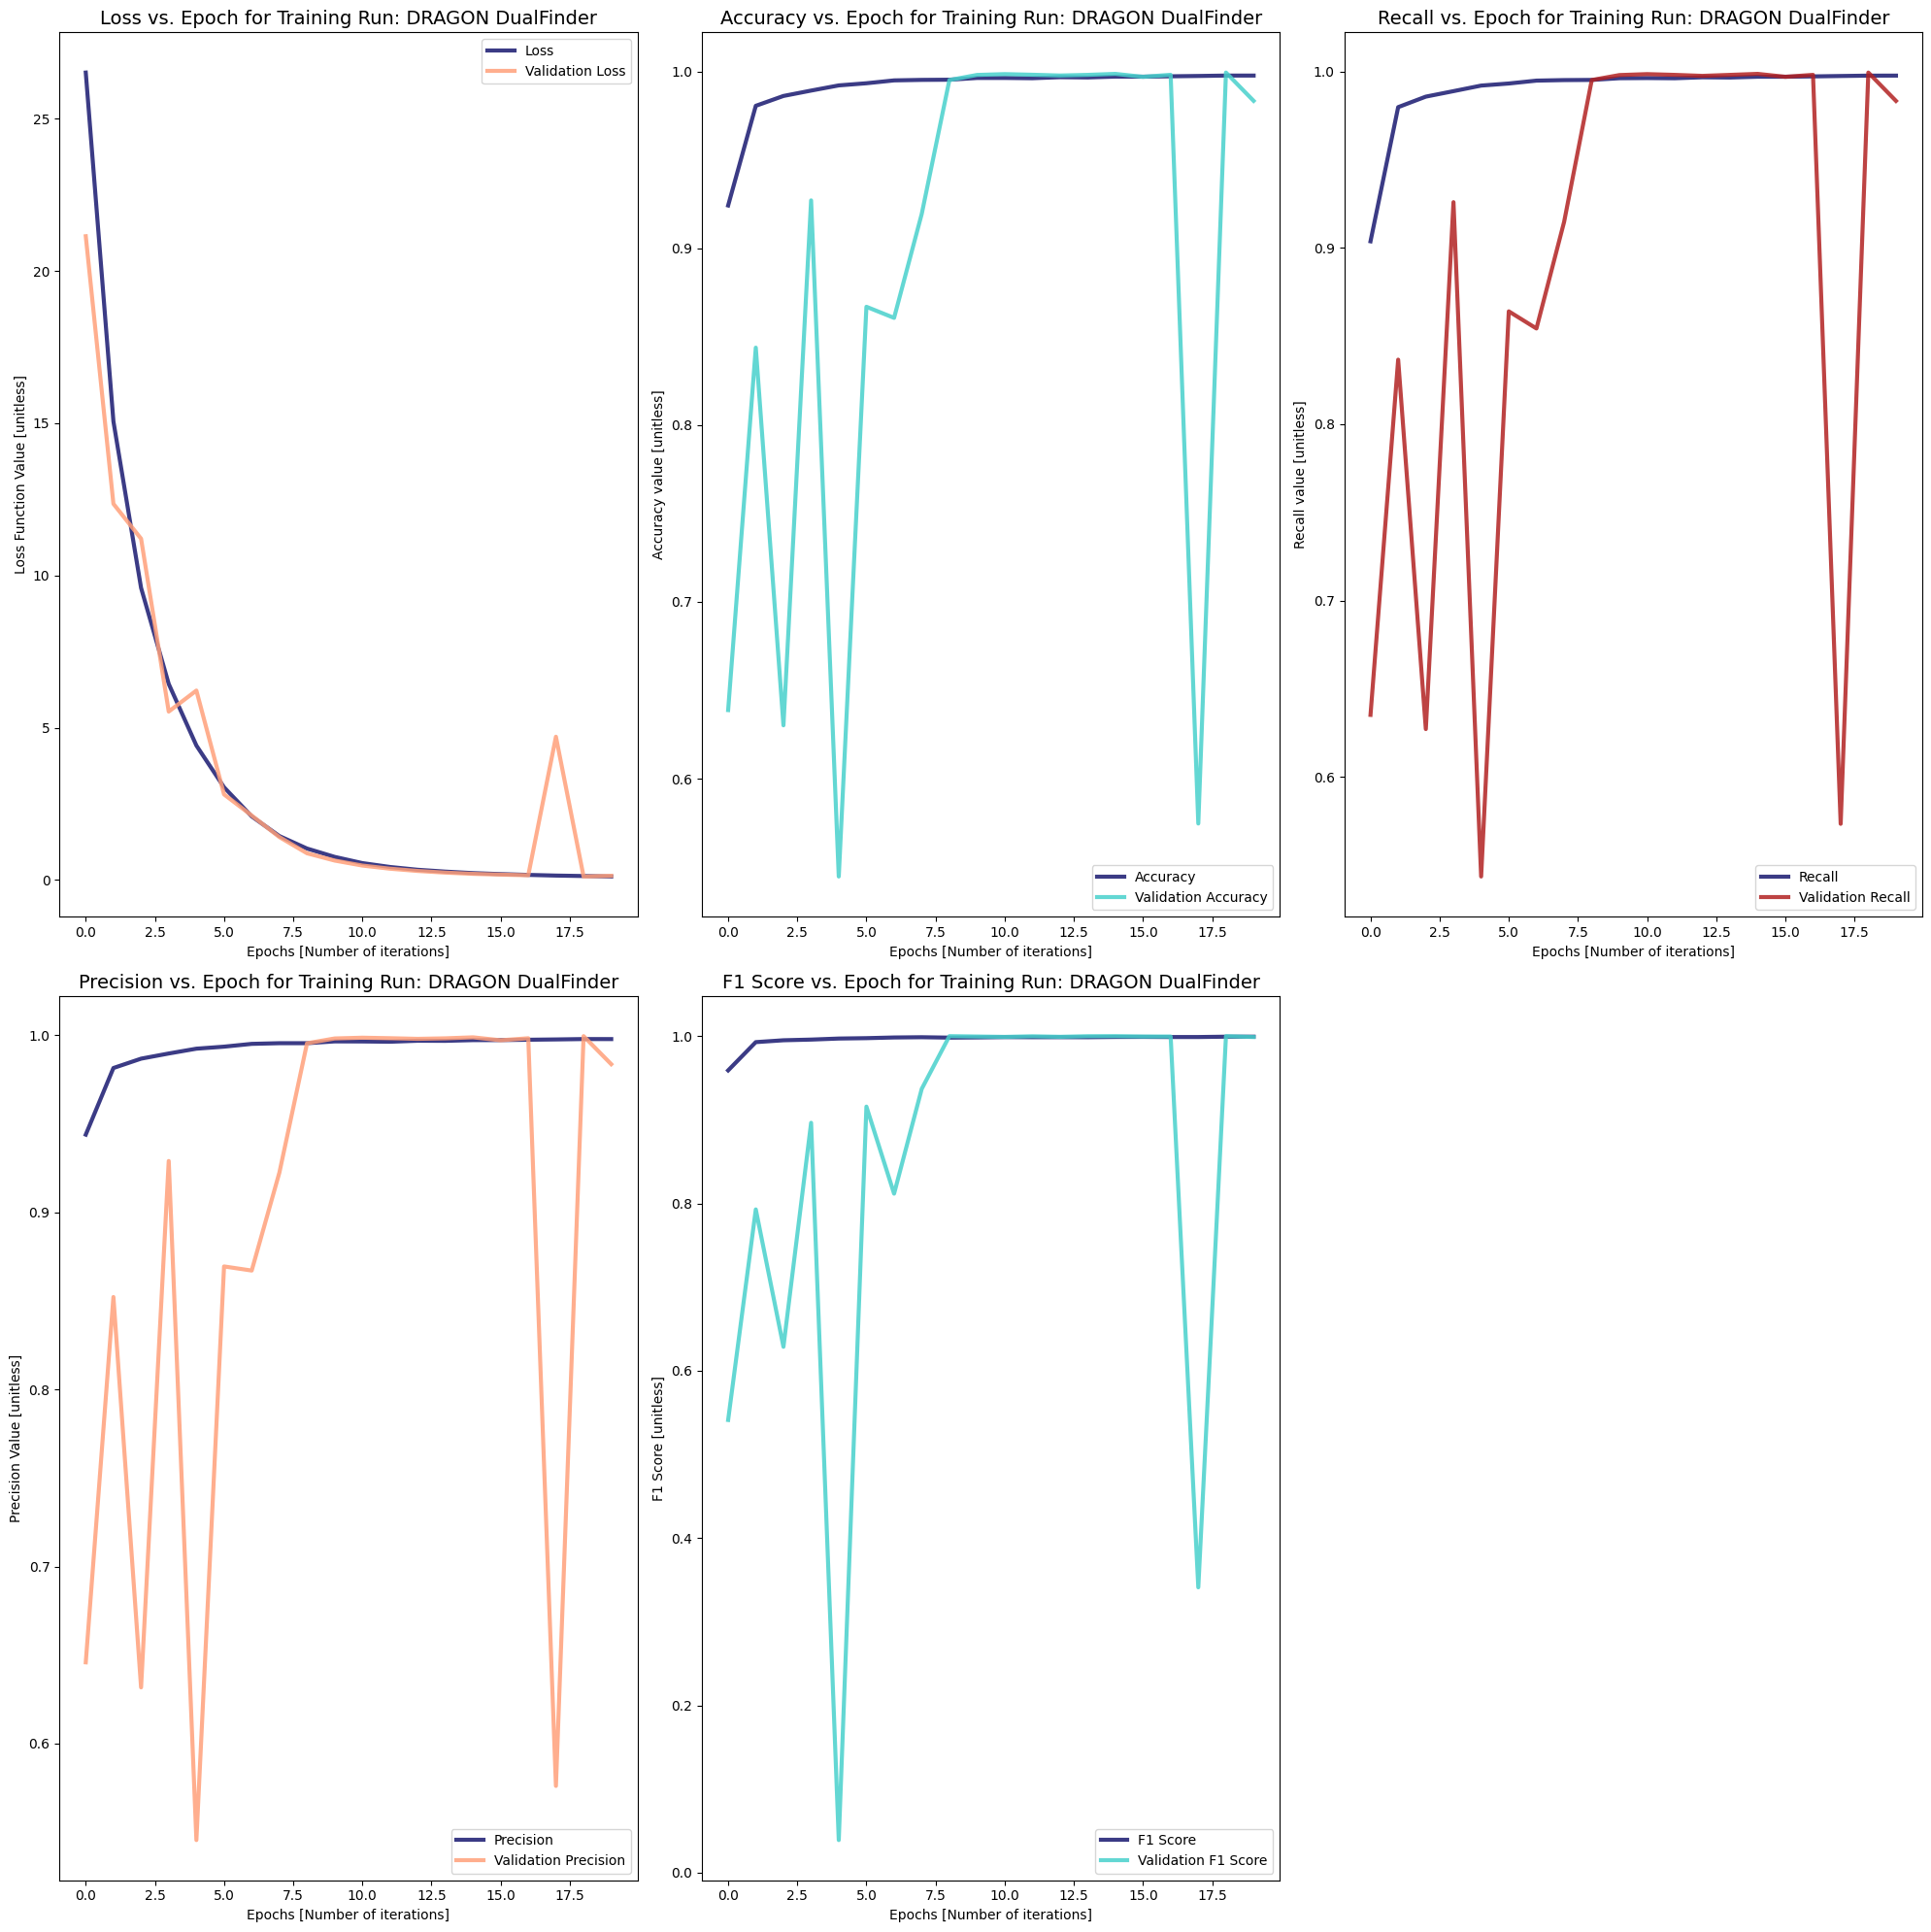

In [17]:
#print(history)
#print(type(history))
#print(history.history)
accuracy = history.history['accuracy']
loss = history.history['loss']
precision = history.history['precision']
recall = history.history['recall']
f1score = history.history['f1_score']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_f1score = history.history['val_f1_score']
training_epochs = np.arange(0, epoch)
fig_save_filepath = 'DRAGON_Dual_Finder/saved_training_figures/'
if not exists(fig_save_filepath):
    os.makedirs(fig_save_filepath)
fig, ax = plot_training_progress(loss, accuracy, training_epochs, save_filepath = fig_save_filepath, training_run = "DRAGON DualFinder",
                                 recall = recall, precision = precision, f1_score = f1score,
                                 val_loss = val_loss, val_acc = val_accuracy, val_recall = val_recall, val_precision = val_precision, 
                                 val_f1_score = val_f1score)

In [18]:
eval_labels_encoded, _ = dual_finder_instance.encode_labels(test_labels, test_labels)
dual_finder_model.evaluate(test_dataset, eval_labels_encoded, batch_size = batch_size, verbose = 1)

['dual_AGN' 'dual_AGN' 'dual_AGN' ... 'offset_AGN' 'star_AGN_align'
 'single_AGN']
['dual_AGN' 'dual_AGN' 'dual_AGN' ... 'offset_AGN' 'star_AGN_align'
 'single_AGN']
Converting to list
Converting to list
332/332 [==============================] - 6s 17ms/step - loss: 0.1344 - accuracy: 0.9836 - precision: 0.9837 - recall: 0.9836 - f1_score: 0.9763


[0.13437330722808838,
 0.9835965037345886,
 0.9836892485618591,
 0.9835965037345886,
 array([0.9968317 , 0.99871236, 0.9169783 , 1.        , 0.9691725 ],
       dtype=float32)]

In [19]:
len("data_preprocessing/training_datasets/")

37

663/663 [==============================] - 6s 9ms/step
data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with predicted label: dual_AGN and confidence: 0.998773992061615
data_preprocessing/training_datasets/dual_AGN_datasets/train_data with predicted label: dual_AGN and confidence: 0.999946117401123
data_preprocessing/training_datasets/dual_AGN_datasets/train_data with predicted label: dual_AGN and confidence: 0.9999219179153442
data_preprocessing/training_datasets/dual_AGN_datasets/train_data with predicted label: single_AGN and confidence: 0.9174101948738098
data_preprocessing/training_datasets/stellar_dataset/train_data/ with predicted label: star_AGN_align and confidence: 0.9997784495353699
data_preprocessing/training_datasets/offset_AGN_datasets/train_data/ with predicted label: offset_AGN and confidence: 0.9999986886978149
data_preprocessing/training_datasets/offset_AGN_datasets/train_data/1 with predicted label: offset_AGN and confidence: 0.9999105930328369
data

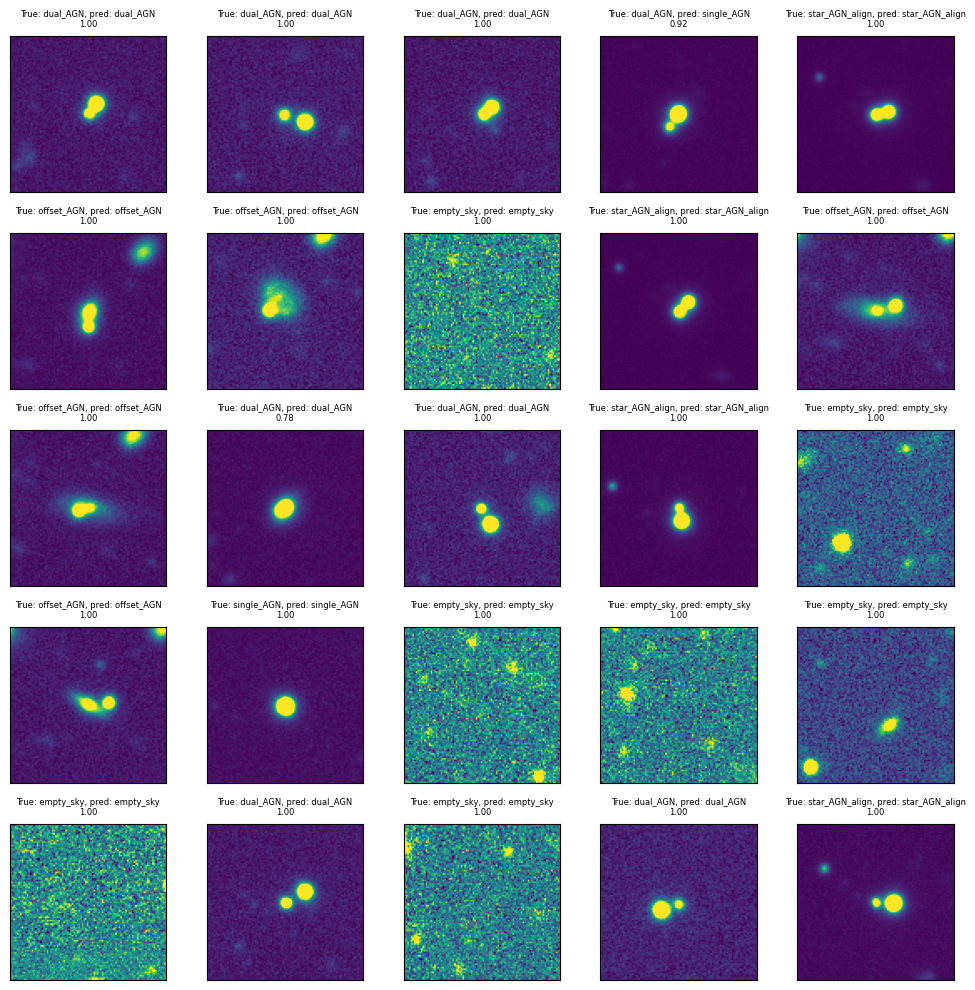

In [21]:
dual_finder_instance.predict(dual_finder_model, test_dataset, test_filepaths, test_labels)